<a href="https://colab.research.google.com/github/dgsob/Deep-Learning-RSS/blob/main/coding%20exercises/exercise3/temperature_anomaly_jax_lstm_rnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
!pip install equinox

In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

# DATA

In [5]:
# Read the data
data = pd.read_csv('/content/Temperature_Anomaly_1880_2021.txt', sep='\s+', header=None, names=['Year', 'TempAnomaly'])

# Extract time series
years = data['Year'].values
temp = data['TempAnomaly'].values

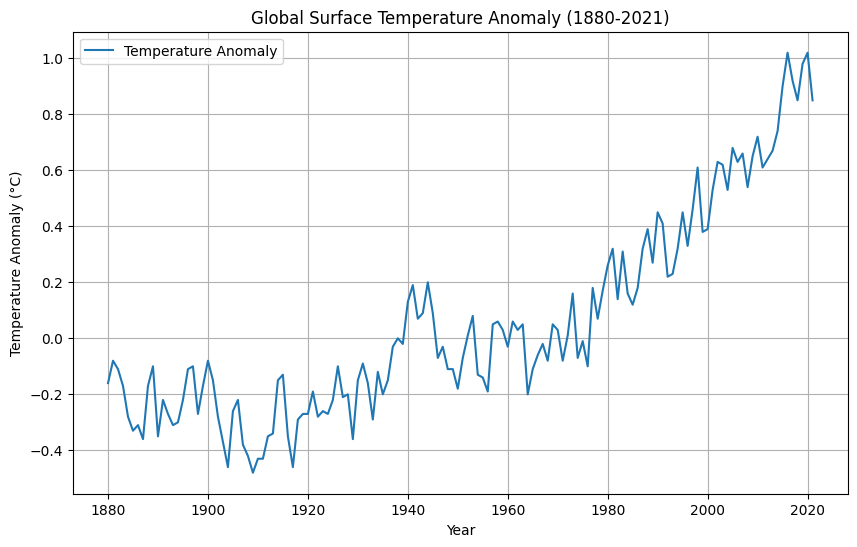

In [6]:
# Plot the time series x(t)
plt.figure(figsize=(10, 6))
plt.plot(years, temp, label='Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Surface Temperature Anomaly (1880-2021)')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return jnp.array(X), jnp.array(y)

In [8]:
SEQ_LENGTH = 2  # <------------------------------------------------------------------
X, y = create_sequences(temp, SEQ_LENGTH)

In [9]:
print(X.shape)
print(y.shape)

(140, 2)
(140,)


In [10]:
# Split into training and test sets (1880-1980 train, 1981-2021 test)
train_size = len(years[years <= 1980]) - SEQ_LENGTH
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# MODEL

In [11]:
class LSTM_RNN(eqx.Module):
    layers: list

    def __init__(self, model_key):
        key1, key2 = jax.random.split(model_key)
        self.layers = [
            eqx.nn.LSTMCell(1, 64, use_bias=True, dtype=jnp.float32, key=key1),
            eqx.nn.Linear(64, 1, use_bias=True, dtype=jnp.float32, key=key2)
        ]

    def __call__(self, x):
        lstm_cell = self.layers[0]
        linear_layer = self.layers[1]

        hidden_state = jnp.zeros((lstm_cell.hidden_size,), dtype=jnp.float32)
        cell_state = jnp.zeros((lstm_cell.hidden_size,), dtype=jnp.float32)
        lstm_state = (hidden_state, cell_state)

        def scan_fun(lstm_state, current_input):
            new_hidden_state, new_cell_state = lstm_cell(current_input.reshape(1,), lstm_state)
            new_lstm_state = (new_hidden_state, new_cell_state)

            return new_lstm_state, None

        final_lstm_state, _ = jax.lax.scan(scan_fun, lstm_state, x)
        final_hidden_state = final_lstm_state[0]
        output = linear_layer(final_hidden_state)

        return output.squeeze()

In [12]:
key = jax.random.PRNGKey(77)
key, subkey = jax.random.split(key)

In [13]:
model = LSTM_RNN(subkey)

In [14]:
print(model)

LSTM_RNN(
  layers=[
    LSTMCell(
      weight_ih=f32[256,1],
      weight_hh=f32[256,64],
      bias=f32[256],
      input_size=1,
      hidden_size=64,
      use_bias=True
    ),
    Linear(
      weight=f32[1,64],
      bias=f32[1],
      in_features=64,
      out_features=1,
      use_bias=True
    )
  ]
)


# LOSS

In [15]:
@eqx.filter_jit
def loss(
    model: LSTM_RNN,
    x: Float[Array, "batch 138 4"],
    y: Float[Array, "batch 138 "]
) -> Float[Array, ""]:
    y_pred = jax.vmap(model)(x)

    return jnp.mean((y_pred - y) ** 2)

In [16]:
# Example loss
loss_value = loss(model, X, y)
print(loss_value)

0.15470006


# OPTIMISER

In [17]:
adam = optax.adam(learning_rate=0.001)  # <-----------------------------------------

In [18]:
# Example inference
output = jax.vmap(model)(X)
print(output.shape)

(140,)


# SINGLE JIT REGION TRAINING STEP

In [19]:
@eqx.filter_jit
def make_step(
    model: LSTM_RNN,
    params: PyTree[Array],
    optim: optax.GradientTransformation,
    x: Float[Array, "batch 138 4"],
    y: Float[Array, "batch 138 "]
):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, params = optim.update(grads, params, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)

    return params, model, loss_value

# TRAINING LOOP

In [20]:
def training_loop(
    model: LSTM_RNN,
    training_data: Float[Array, "batch 138 4"],
    training_labels: Float[Array, "batch 138 "],
    test_data: Float[Array, "batch 138 4"],
    test_labels: Float[Array, "batch 138 "],
    optim: optax.GradientTransformation,
    num_steps: int,
    print_every: int
) -> LSTM_RNN:

    params = optim.init(eqx.filter(model, eqx.is_array))

    for step in range(num_steps):
        params, model, loss_value = make_step(model, params, optim, training_data, training_labels)

        if step % print_every == 0 or step == num_steps-1:
            print(f"Step {step}, Loss: {loss_value}")

    return model

In [21]:
NUM_STEPS = 1000
PRINT_EVERY = 100

In [22]:
model = training_loop(model, X_train, y_train, X_test, y_test, adam, NUM_STEPS, PRINT_EVERY)

Step 0, Loss: 0.03449626266956329
Step 100, Loss: 0.013940960168838501
Step 200, Loss: 0.01216857135295868
Step 300, Loss: 0.011055795475840569
Step 400, Loss: 0.010933837853372097
Step 500, Loss: 0.010906688868999481
Step 600, Loss: 0.010883710347115993
Step 700, Loss: 0.01086687296628952
Step 800, Loss: 0.010850210674107075
Step 900, Loss: 0.010831653140485287
Step 999, Loss: 0.010809642262756824


In [23]:
def evaluate(model: LSTM_RNN, X_test: Float[Array, "batch 138 4"], y_test: Float[Array, "batch 138 "]):
    y_pred = jax.vmap(model)(X_test)
    total_loss = loss(model, X_test, y_test)


    return y_pred, total_loss

In [24]:
test_pred, final_loss = evaluate(model, X_test, y_test)
print(f"Final Test Loss: {final_loss}")

Final Test Loss: 0.017766937613487244


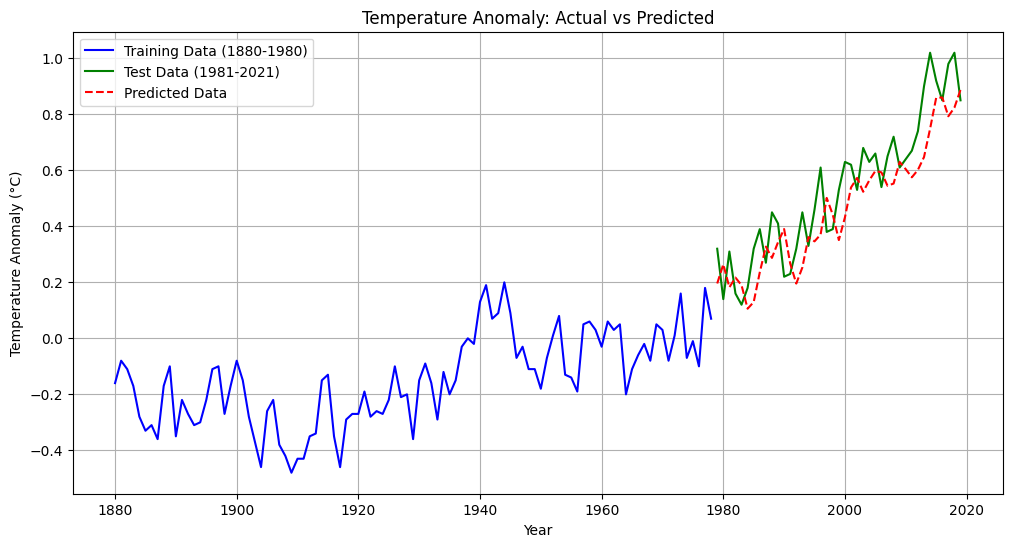

In [25]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(years[:train_size], temp[:train_size], label='Training Data (1880-1980)', color='blue')
plt.plot(years[train_size:train_size+len(y_test)], y_test, label='Test Data (1981-2021)', color='green')
plt.plot(years[train_size:train_size+len(test_pred)], test_pred, label='Predicted Data', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomaly: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()